In [1]:
!pip install timesfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00


In [2]:
import timesfm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0].


In [3]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    "#000072", # blue
    "#80c21d", # green
    "#924eae", # purple
    "#ff0000", # red
    "#ff9100", # orange
])

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/marcopeix/FoundationModelsForTimeSeriesForecasting/main/data/walmart_sales_small.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [5]:
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="cpu", # "gpu" if CUDA is available
          per_core_batch_size=32,
          horizon_len=8,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.35k [00:00<?, ?B/s]

torch_model.ckpt:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

In [6]:
df = df.rename(columns={"Store": "unique_id", "Date": "ds"})
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,unique_id,ds,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [7]:
preds_df = tfm.forecast_on_df(
    inputs=df,
    freq="W",
    value_name="Weekly_Sales",
    num_jobs=-1
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [8]:
preds_df.head()

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,2012-10-28,1568671.875,1448417.750,1488222.500,1521048.250,1542119.875,1568671.875,1592452.75,1619977.375,1657727.000,1707236.625
1,1,2012-11-04,1627053.750,1508356.750,1549427.125,1576796.875,1601039.000,1627053.750,1650516.75,1679305.750,1714782.375,1765154.750
2,1,2012-11-11,1653684.125,1524701.000,1568835.875,1598771.500,1627074.750,1653684.125,1679590.75,1710439.000,1753518.000,1812493.250
3,1,2012-11-18,1671083.500,1527738.000,1576693.000,1612349.875,1643436.500,1671083.500,1704931.00,1740059.750,1783028.250,1855970.000
4,1,2012-11-25,1671467.750,1498093.375,1555083.000,1598249.625,1638091.000,1671467.750,1710975.25,1752939.500,1802803.750,1884323.125


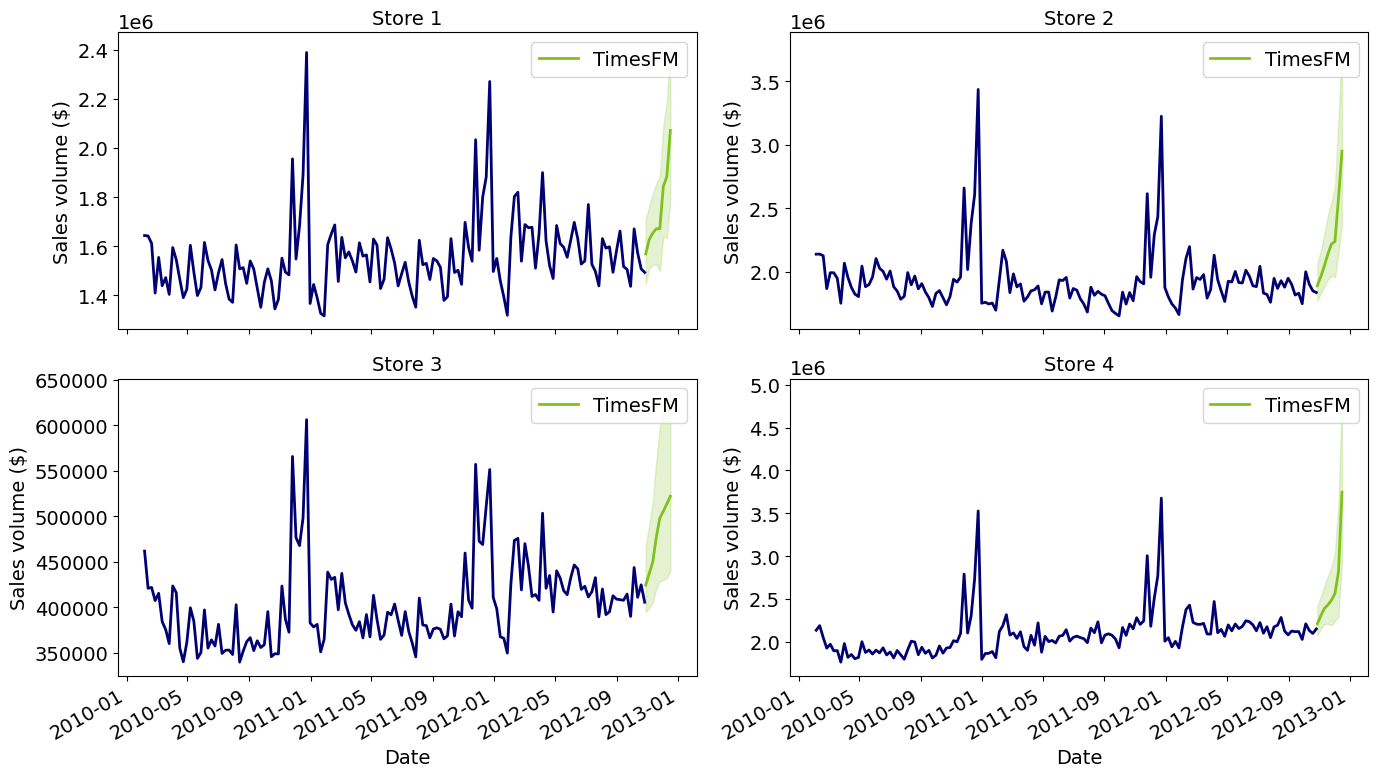

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

for i, ax in enumerate(axes.flatten()):
    store_id = i+1
    data = df.query("unique_id == @store_id")
    preds = preds_df.query("unique_id == @store_id")

    ax.plot(data['ds'], data['Weekly_Sales'])
    ax.plot(preds['ds'], preds['timesfm'], label='TimesFM')
    ax.fill_between(preds['ds'], preds['timesfm-q-0.1'], preds['timesfm-q-0.9'], color="#80c21d", alpha=0.2)

    ax.set_title(f"Store {store_id}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales volume ($)')
    ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

## Cross-validation with TimesFM

In [10]:
def cross_validation_timesfm(df, h, n_windows, target_col, freq):
  all_preds = []

  for i in range(n_windows, 0, -1):
    input_df = df.iloc[:-(h*i)]

    preds_df = tfm.forecast_on_df(
    inputs=input_df,
    freq=freq,
    value_name=target_col,
    num_jobs=-1
    )

    all_preds.append(preds_df)

  preds = pd.concat(all_preds, axis=0, ignore_index=True)

  return preds

In [11]:
cv_df = df.query("unique_id == 1")

In [12]:
cv_preds = cross_validation_timesfm(
    df=cv_df,
    h=8,
    n_windows=4,
    target_col="Weekly_Sales",
    freq="W")

cv_preds.head()

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,2012-03-18,1621625.375,1465747.125,1516343.250,1555531.250,1587567.250,1621625.375,1656559.500,1698278.250,1753464.000,1844324.500
1,1,2012-03-25,1634064.875,1469694.750,1521617.250,1561141.125,1596940.500,1634064.875,1673763.750,1719128.250,1780867.750,1883812.250
2,1,2012-04-01,1641014.375,1468005.000,1521347.750,1561576.625,1600617.000,1641014.375,1685151.625,1737651.750,1806150.000,1920253.125
3,1,2012-04-08,1635624.125,1458029.250,1511760.000,1554381.000,1594871.125,1635624.125,1682416.750,1736385.250,1808363.500,1928730.875
4,1,2012-04-15,1626995.000,1450907.125,1502576.125,1544985.000,1584879.375,1626995.000,1673782.125,1730081.125,1803576.625,1928450.375


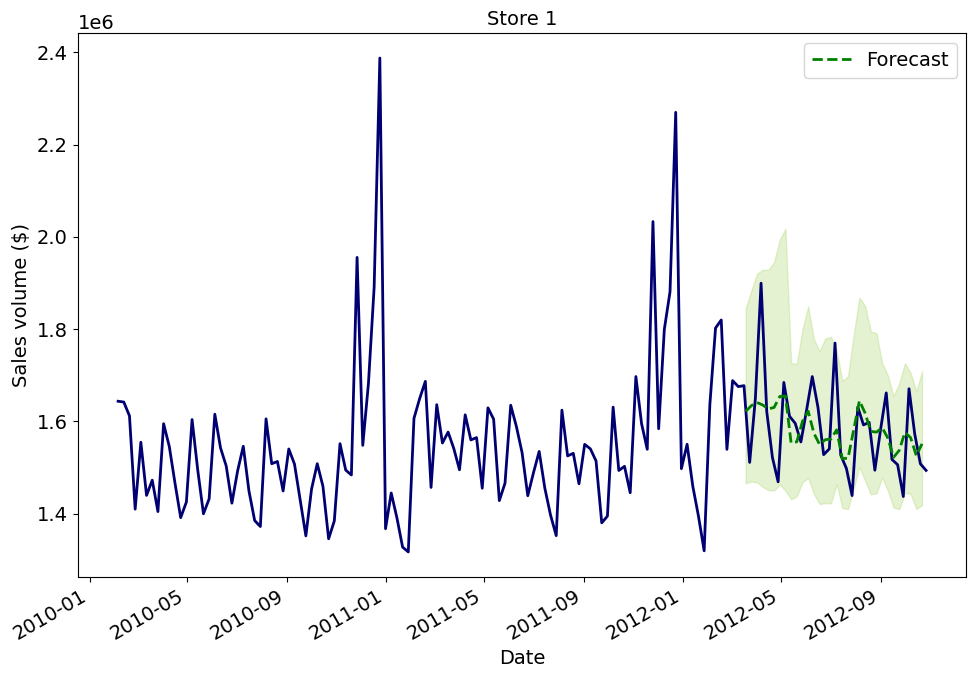

In [13]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(cv_df['ds'], cv_df['Weekly_Sales'])
ax.plot(cv_preds['ds'], cv_preds['timesfm'], ls='--', color='green', label='Forecast')
ax.fill_between(cv_preds['ds'], cv_preds['timesfm-q-0.1'], cv_preds['timesfm-q-0.9'], color="#80c21d", alpha=0.2)

ax.set_title(f"Store 1")
ax.set_xlabel('Date')
ax.set_ylabel('Sales volume ($)')
ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

In [14]:
eval_df = cv_preds[['unique_id', 'ds', 'timesfm']]
eval_df['Weekly_Sales'] = cv_df['Weekly_Sales'][-32:].values

In [15]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    models=['timesfm'],
    target_col='Weekly_Sales',
    id_col='unique_id'
)

evaluation

,unique_id,metric,timesfm
0,1,mae,61684.467969
1,1,smape,0.019244


## Forecasting with covariates

In [16]:
train = cv_df[:-32]
test = cv_df[-32:]

train.head()

,unique_id,ds,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [17]:
from collections import defaultdict

# Data pipelining
def get_batched_data_fn(
    batch_size: int = 2,
    context_len: int = 64,
    horizon_len: int = 32,
):
    examples = defaultdict(list)

    num_examples = 0
    for start in range(0, len(cv_df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        examples["inputs"].append(train["Weekly_Sales"][start:(context_end := start + context_len)].tolist())
        examples["Holiday_Flag"].append(train["Holiday_Flag"][start:context_end + horizon_len].tolist())
        examples["outputs"].append(train["Weekly_Sales"][context_end:(context_end + horizon_len)].tolist())

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size) : ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [18]:
tfm_h32 = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="cpu", # "gpu" if CUDA is available
          per_core_batch_size=32,
          horizon_len=32,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
input_data = get_batched_data_fn()

for i, example in enumerate(input_data()):
    cov_forecast, _ = tfm_h32.forecast_with_covariates(
        inputs=example["inputs"],
        dynamic_numerical_covariates={},
        dynamic_categorical_covariates={
            "Holiday_Flag": example["Holiday_Flag"],
        },
        static_numerical_covariates={},
        static_categorical_covariates={},
        freq=[1] * len(example["inputs"]),
        xreg_mode="xreg + timesfm",
        ridge=0.0,
        force_on_cpu=False,
        normalize_xreg_target_per_input=True,
    )
    print(f"Done with round {i}")

Done with round 0


In [20]:
cov_forecast[0]

array([1569214.55777514, 1564500.87930074, 1572623.15279745,
       1554760.89455167, 1544569.06460048, 1554830.69355728,
       1549119.56393275, 1531271.40012867, 1525488.31867663,
       1528050.69293471, 1544812.53091588, 1528106.69484971,
       1546030.5428322 , 1536480.21574517, 1544179.88673542,
       1536273.84457302, 1531001.00569849, 1543826.58606356,
       1537811.8110205 , 1658650.85778137, 1519330.97211143,
       1521529.17929939, 1530726.34368547, 1515683.42099506,
       1528854.47099367, 1530636.64832367, 1533087.78234933,
       1527317.15633978, 1520124.445171  , 1531830.71039375,
       1672573.28306153, 1530324.97204688])

In [21]:
no_cov_preds = tfm_h32.forecast_on_df(
    inputs=train,
    freq="W",
    value_name="Weekly_Sales",
    num_jobs=-1
)

no_cov_preds.head()

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,2012-03-18,1621625.375,1465747.125,1516343.250,1555531.250,1587567.250,1621625.375,1656559.500,1698278.250,1753464.000,1844324.500
1,1,2012-03-25,1634064.875,1469694.750,1521617.250,1561141.125,1596940.500,1634064.875,1673763.750,1719128.250,1780867.750,1883812.250
2,1,2012-04-01,1641014.375,1468005.000,1521347.750,1561576.625,1600617.000,1641014.375,1685151.625,1737651.750,1806150.000,1920253.125
3,1,2012-04-08,1635624.125,1458029.250,1511760.000,1554381.000,1594871.125,1635624.125,1682416.750,1736385.250,1808363.500,1928730.875
4,1,2012-04-15,1626995.000,1450907.125,1502576.125,1544985.000,1584879.375,1626995.000,1673782.125,1730081.125,1803576.625,1928450.375


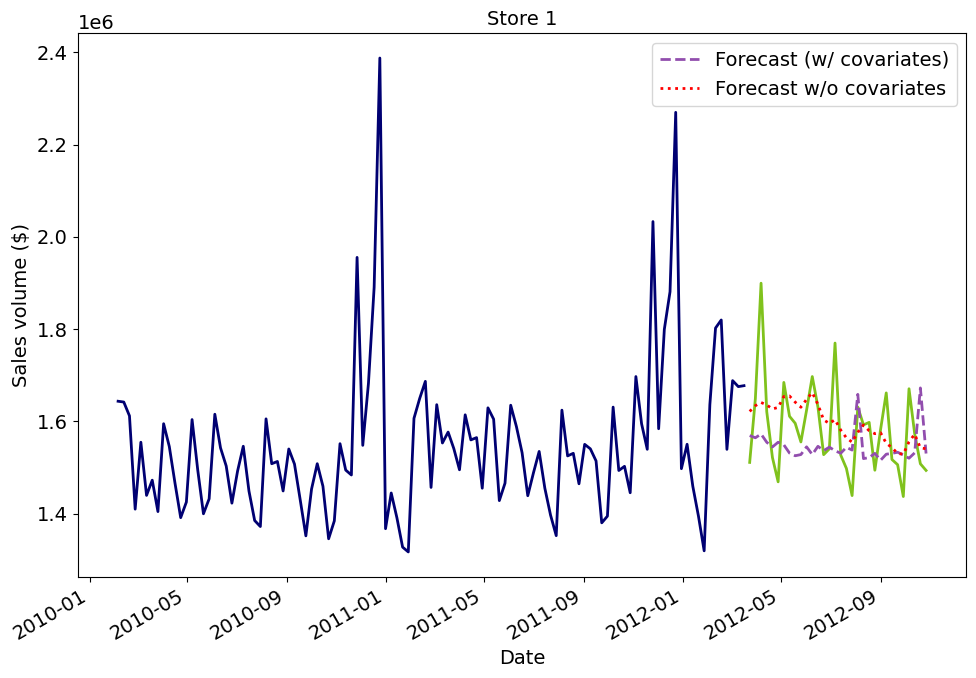

In [22]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(train['ds'], train['Weekly_Sales'])
ax.plot(test['ds'], test['Weekly_Sales'])
ax.plot(test['ds'], cov_forecast[0], ls='--', label='Forecast (w/ covariates)')
ax.plot(test['ds'], no_cov_preds['timesfm'], ls=':', label='Forecast w/o covariates')

ax.set_title(f"Store 1")
ax.set_xlabel('Date')
ax.set_ylabel('Sales volume ($)')
ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

eval_df = test[['unique_id', 'ds', 'Weekly_Sales']]
eval_df['timesfm_cov'] = cov_forecast[0]
eval_df['timesfm'] = no_cov_preds['timesfm'].values

evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    models=['timesfm', 'timesfm_cov'],
    target_col='Weekly_Sales',
    id_col='unique_id'
)

evaluation

,unique_id,metric,timesfm,timesfm_cov
0,1,mae,64578.515312,81960.536250
1,1,smape,0.020201,0.025718


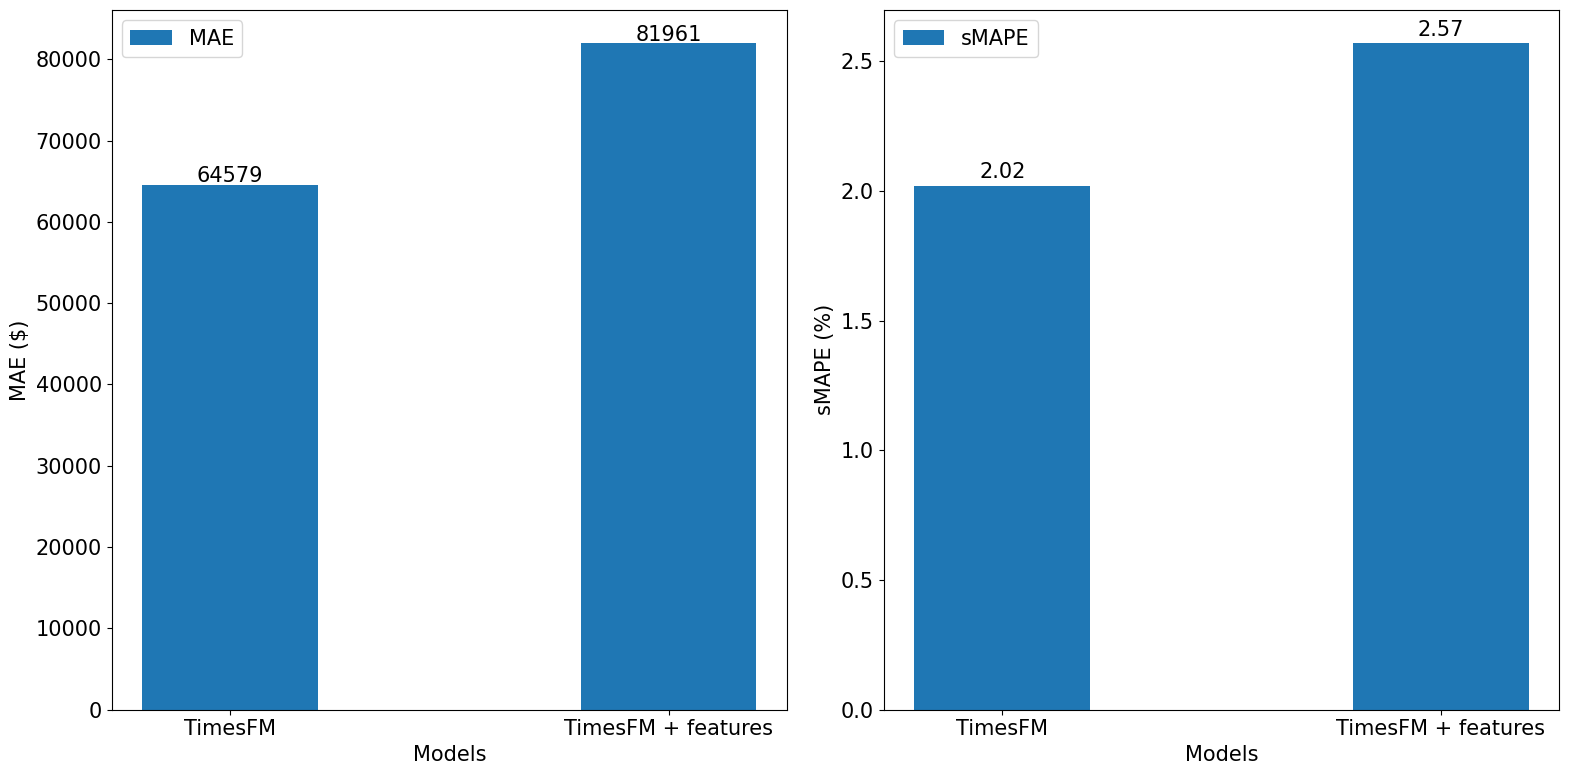

In [ ]:
plt.rcParams.update({'font.size': 15})
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['TimesFM', 'TimesFM + features']
y_mae = [64579, 81961]
y_smape = [2.02, 2.57]

ax1.bar(x, y_mae, width=0.4, label='MAE')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE ($)')
ax1.legend()

for i, v in enumerate(y_mae):
    ax1.text(x=i, y=v+300, s=str(v), ha='center')

ax2.bar(x, y_smape, width=0.4, label='sMAPE')
ax2.set_xlabel('Models')
ax2.set_ylabel('sMAPE (%)')
ax2.legend()

for i, v in enumerate(y_smape):
    ax2.text(x=i, y=v+.03, s=str(v), ha='center')

plt.tight_layout()